# Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Using cuda.


# Part 1 - Setup and baseline

# Load data

In [ ]:
batch_size = 64

train_dataset = dsets.CIFAR10(root='./data', train=True, # Read training set
                              download=True, transform=transforms.ToTensor())
test_dataset = dsets.CIFAR10(root='./data', train=False, # Read test set
                        download=True, transform=transforms.ToTensor())
train_dataset, _ = train_test_split(train_dataset, train_size=0.1, stratify=train_dataset.targets, random_state=1) # Extract 10% of the data
_, test_dataset = train_test_split(test_dataset, test_size=0.1, stratify=test_dataset.targets, random_state=1) # Extract 10% of the data

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, # Partition to batches
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, # Partition to batches
                                         shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 46233838.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Train and test a simple SVM model

In [ ]:
X_train = np.array([np.array(image).flatten() for image, label in train_dataset]) # Extract features for SVM
X_test = np.array([np.array(image).flatten() for image, label in test_dataset]) # Extract features for SVM
y_train = np.array([label for image, label in train_dataset]) # Extract labels for SVM
y_test = np.array([label for image, label in test_dataset]) # Extract labels for SVM

In [ ]:
linear_svm = svm.SVC(kernel="linear")
linear_svm.fit(X_train, y_train)
rbf_svm = svm.SVC(kernel="rbf")
rbf_svm.fit(X_train, y_train)

In [ ]:
print(f'Linear SVM train accuracy: {linear_svm.score(X_train, y_train)}')
print(f'Linear SVM test accuracy: {linear_svm.score(X_test, y_test)}')
print(f'RBF SVM train accuracy: {rbf_svm.score(X_train, y_train)}')
print(f'RBF SVM test accuracy: {rbf_svm.score(X_test, y_test)}')

Linear SVM train accuracy: 0.99
Linear SVM test accuracy: 0.30
RBF SVM train accuracy: 0.73
RBF SVM test accuracy: 0.43


# General training and test functions



In [ ]:
input_size = 32*32*3 # Flattened size

def train(optimizer, criterion, net, input_size=input_size, num_epoch=50, history=False, training=train_loader, test=test_loader, conv=False):
  '''
  Trains the given net w.r.t the given criterion using the given optimizer.
  Input_size is the size of the flattened features vector (in the case of a FFNet).
  num_epoch is the number of epochs to train over.
  history is a flag for returning the loss and accuracy histories over the training epochs.
  training and test are the dataloader objects to train and test over.
  conv is a flag for the given net being a ConvNet and not a FFNet.
  '''

  if history:
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
  for epoch in range(num_epoch):
      if history:
        train_losses.append(0)
      for i, (images, labels) in enumerate(training): # For each batch in training
          # Convert torch tensor to Variable
          if not conv: # Flatten image
            images = Variable(images.view(-1, input_size))
          labels = Variable(labels)
          # Backpropagation
          pred = net(images) # Forward pass
          loss = criterion(pred, labels) # Current loss
          optimizer.zero_grad()
          loss.backward() # Backward pass
          optimizer.step() # Optimize
          if history:
            train_losses[epoch] += loss.item() # Sum losses
          # print(f'Epoch: {epoch+1}, Batch: {i+1}, Training Loss: {loss/len(training)}')
      if history:
        train_losses[epoch] /= len(training) # Average losses in epoch

      if history:
        test_losses.append(0)
        for i, (images, labels) in enumerate(test): # For each batch in test
            # Convert torch tensor to Variable
            if not conv: # Flatten image
              images = Variable(images.view(-1, input_size))
            labels = Variable(labels)
            # Predict on images and sum loss
            pred = net(images)
            test_losses[epoch] += criterion(pred, labels).item()
            # print(f'Epoch: {epoch+1}, Batch: {i+1}, Test Loss: {criterion(pred, labels).item()/len(test)}')
        test_losses[epoch] /= len(test) # Average losses in epoch

      if history: # Compute accuracies in training and in test
        train_accuracies.append(accuracy(net, input_size=input_size, train_acc=True, training=training, conv=conv))
        test_accuracies.append(accuracy(net, input_size=input_size, train_acc=False, test=test, conv=conv))
  if history:
    return (train_losses, test_losses, train_accuracies, test_accuracies)
  else:
    return

def accuracy(net, input_size=input_size, train_acc=False, training=train_loader, test=test_loader, conv=False):
  '''
  Calculates the accuracy of the given net.
  Input_size is the size of the flattened features vector (in the case of a FFNet).
  train_acc is a flag for returning the training accuracy (instead of the test accuracy)
  training and test are the dataloader objects to train and test over.
  conv is a flag for the given net being a ConvNet and not a FFNet.
  '''
  correct = 0
  total = 0
  if (train_acc):
    for images, labels in training: # For each batch
        if not conv: # Flatten image
          images = Variable(images.view(-1, input_size))
        correct += torch.sum(torch.argmax(net(images), axis = 1) == labels) # Compute correct predictions
        total += labels.size(0)
  else:
    for images, labels in test: # For each batch
      if not conv: # Flatten image
        images = Variable(images.view(-1, input_size))
      correct += torch.sum(torch.argmax(net(images), axis = 1) == labels) # Compute correct predictions
      total += labels.size(0)
  return correct.item() / total

# Part 2 - Feed forward neural net

## Section 1
### General feed forward network setup

In [ ]:
class FFNet(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=256, output_size=10, depth=1, xavier=False, std=1, dropout=False, p=0.5):
        '''
        Initializes a FFNet that receives feature vectors of size input_size. 
        Each hidden layer has hidden_size neurons.
        The output layer is of size output_size.
        The net has depth hidden layers.
        xavier is a flag for initializing the net's weights with xavier's initialization.
        std is a parameter used for the normal initialization of the weights.
        dropout is a flag for including a dropout layer after every hidden layer.
        The dropout probability is p.
        '''
        super(FFNet, self).__init__()
        self.std = std # Standard deviation for normal init.
        self.model = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU()) # Base setup
        if dropout: # Dropout layer
          self.model.append(nn.Dropout(p))
        for l in range(depth-1): # Depth
          self.model.append(nn.Linear(hidden_size, hidden_size))
          self.model.append(nn.ReLU())
          if dropout: # Dropout layer
            self.model.append(nn.Dropout(p))
        self.model.append(nn.Linear(hidden_size, output_size)) # Output layer
        if xavier: # Xavier init.
          self.apply(self.xavier_init)
        else: # Normal init.
          self.apply(self.normal_init)

    def xavier_init(self, module):
      if type(module) == nn.Linear:
        torch.nn.init.xavier_uniform_(module.weight)
        torch.nn.init.zeros_(module.bias)

    def normal_init(self, module):
      if type(module) == nn.Linear:
        torch.nn.init.normal_(module.weight, mean=0, std=self.std)
        torch.nn.init.normal_(module.bias, mean=0, std=self.std)
    
    def forward(self, x):
        out = self.model(x)
        return out

### Hyperparameters grid search

In [ ]:
num_epoch = 25
best_accuracy = 0
best_hyperparams = (0, 0, 0)

for std in [2**i for i in range(-4,2)]:
  for lr in [10**(-i) for i in range(1, 4)]:
    for momentum in [0.95-(i*0.1) for i in range(4)]:
      net = FFNet(std=std) # Initialize net
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum) # Initialize optimizer
      train(optimizer, criterion, net, num_epoch=num_epoch, history=False) # Train model
      curr_accuracy = accuracy(net, train_acc=False) # Compute accuracy
      if (best_accuracy <= curr_accuracy):
        best_accuracy = curr_accuracy
        best_hyperparams = (std, lr, momentum)

std: 0.0625, lr: 0.1, momentum: 0.95
0.1
std: 0.0625, lr: 0.1, momentum: 0.85


KeyboardInterrupt: ignored

### Best configuration evaluation

In [ ]:
num_epoch = 75
net = FFNet(std=best_hyperparams[0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
base_train_losses, base_test_losses, base_train_accuracies, base_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, history=True)

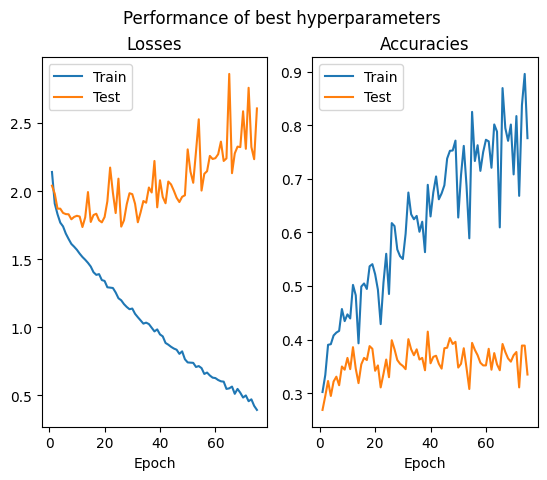

0.3924549137112461 2.607557028532028 0.7758 0.335


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), base_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), base_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), base_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), base_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle('Performance of best hyperparameters')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(base_train_losses[-1], base_test_losses[-1], base_train_accuracies[-1], base_test_accuracies[-1])

## Section 2 - Adam optimizer

In [ ]:
net = FFNet(std=best_hyperparams[0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=best_hyperparams[1])
adam_train_losses, adam_test_losses, adam_train_accuracies, adam_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, history=True)

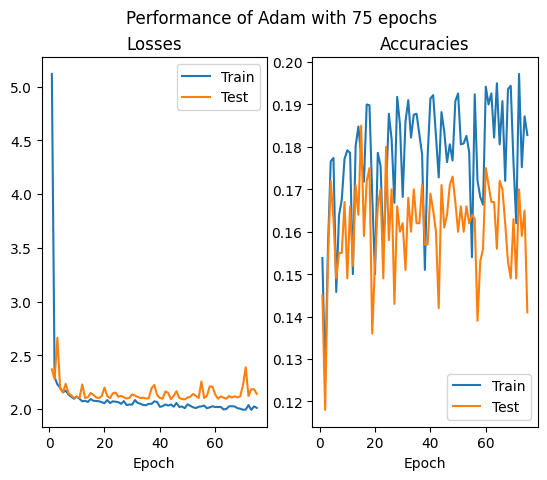

2.009649071512343 2.141038089990616 0.1828 0.141


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), adam_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), adam_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), adam_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), adam_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle(f'Performance of Adam with {num_epoch} epochs')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(adam_train_losses[-1], adam_test_losses[-1], adam_train_accuracies[-1], adam_test_accuracies[-1])

In [ ]:
net = FFNet(std=best_hyperparams[0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
adam_train_losses, adam_test_losses, adam_train_accuracies, adam_test_accuracies = train(optimizer, criterion, net, num_epoch=100, history=True)

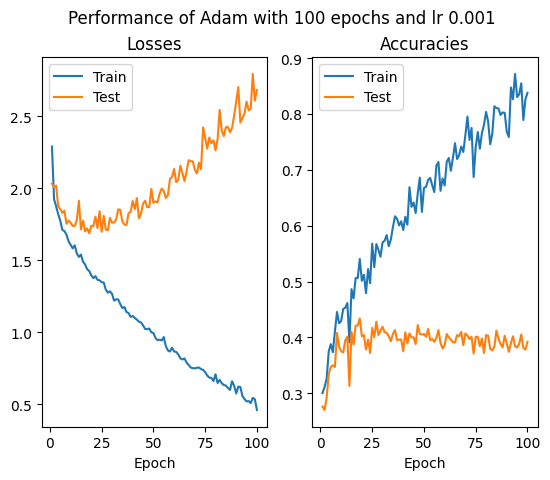

0.4605202369297607 2.6808229982852936 0.838 0.392


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, 100+1), adam_train_losses, label = "Train")
plt.plot(range(1, 100+1), adam_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, 100+1), adam_train_accuracies, label = "Train")
plt.plot(range(1, 100+1), adam_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle(f'Performance of Adam with {100} epochs and lr {0.001}')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(adam_train_losses[-1], adam_test_losses[-1], adam_train_accuracies[-1], adam_test_accuracies[-1])

## Section 3 - Xavier initialization

In [ ]:
net = FFNet(xavier=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
xav_train_losses, xav_test_losses, xav_train_accuracies, xav_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, history=True)

KeyboardInterrupt: ignored

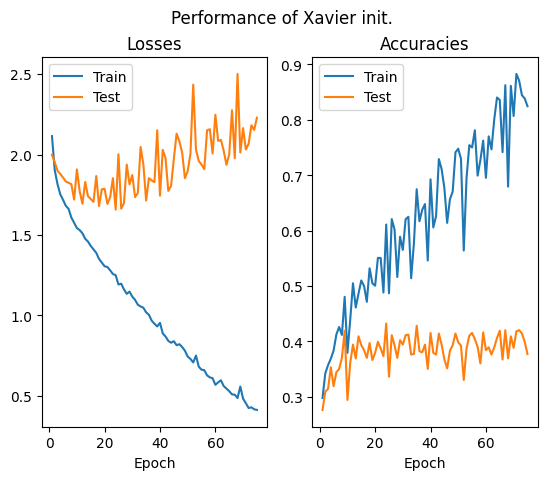

0.41242005327079867 2.2289058789610863 0.8246 0.377


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), xav_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), xav_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), xav_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), xav_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle('Performance of Xavier init.')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(xav_train_losses[-1], xav_test_losses[-1], xav_train_accuracies[-1], xav_test_accuracies[-1])

## Section 4 - Regularization
### Weight decay

In [ ]:
net = FFNet(std=best_hyperparams[0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2], weight_decay=0.2)
wd_train_losses, wd_test_losses, wd_train_accuracies, wd_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, history=True)

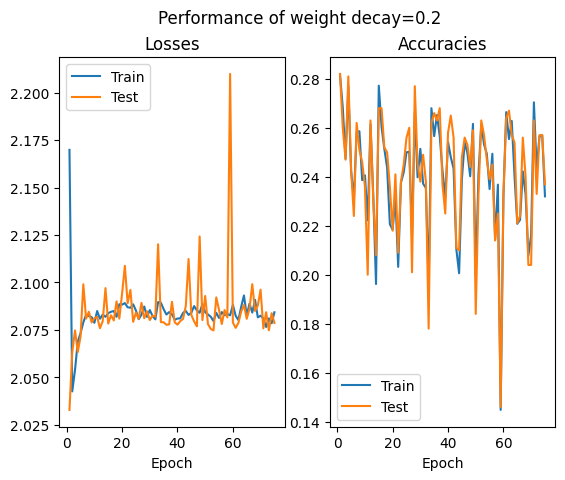

2.0843061163455627 2.0786462128162384 0.232 0.237


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), wd_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), wd_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), wd_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), wd_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle('Performance of weight decay=0.2')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(wd_train_losses[-1], wd_test_losses[-1], wd_train_accuracies[-1], wd_test_accuracies[-1])

### Dropout

In [ ]:
net = FFNet(std=best_hyperparams[0], dropout=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
drop_train_losses, drop_test_losses, drop_train_accuracies, drop_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, history=True)

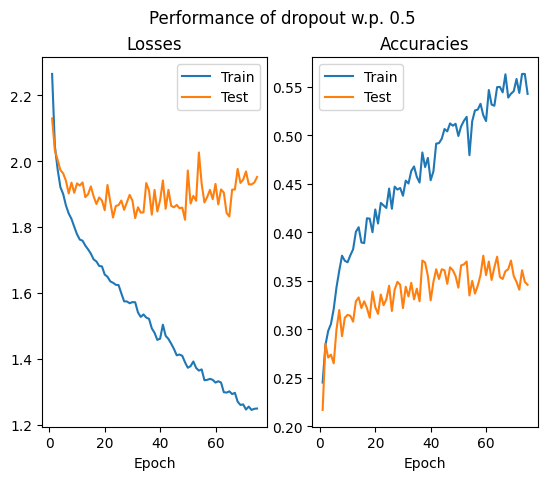

1.2496881892409506 1.9519257321953773 0.5428 0.346


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), drop_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), drop_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), drop_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), drop_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle('Performance of dropout w.p. 0.5')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(drop_train_losses[-1], drop_test_losses[-1], drop_train_accuracies[-1], drop_test_accuracies[-1])

## Section 5 - PCA whitening

In [ ]:
n_components_root = 10
pca = PCA(n_components_root ** 2, whiten=True)
pca.fit(np.concatenate((X_train, X_test), axis=0))

PCA(n_components=100, whiten=True)

In [ ]:
def PCA_transform(image, model=pca, n_components_root=n_components_root):
  X = transforms.functional.to_tensor(image)
  X = np.array(X).flatten()
  X = model.transform(X.reshape(1, -1))
  return torch.Tensor(X.reshape((n_components_root, n_components_root)))

In [ ]:
train_dataset_pca = dsets.CIFAR10(root='./data', train=True, # Read training set
                              download=True, transform=PCA_transform)
test_dataset_pca = dsets.CIFAR10(root='./data', train=False, # Read test set
                        download=True, transform=PCA_transform)
train_dataset_pca, _ = train_test_split(train_dataset_pca, train_size=0.1, stratify=train_dataset_pca.targets, random_state=1) # Extract 10% of the data
_, test_dataset_pca = train_test_split(test_dataset_pca, test_size=0.1, stratify=test_dataset_pca.targets, random_state=1) # Extract 10% of the data

train_loader_pca = torch.utils.data.DataLoader(train_dataset_pca, batch_size=batch_size, # Partition to batches
                                          shuffle=True)
test_loader_pca = torch.utils.data.DataLoader(test_dataset_pca, batch_size=batch_size, # Partition to batches
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
net = FFNet(input_size=(n_components_root ** 2), std=best_hyperparams[0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
pca_train_losses, pca_test_losses, pca_train_accuracies, pca_test_accuracies = train(optimizer, criterion, net, input_size=(n_components_root ** 2),
                                                                                     num_epoch=num_epoch, history=True, training=train_loader_pca, test=test_loader_pca)

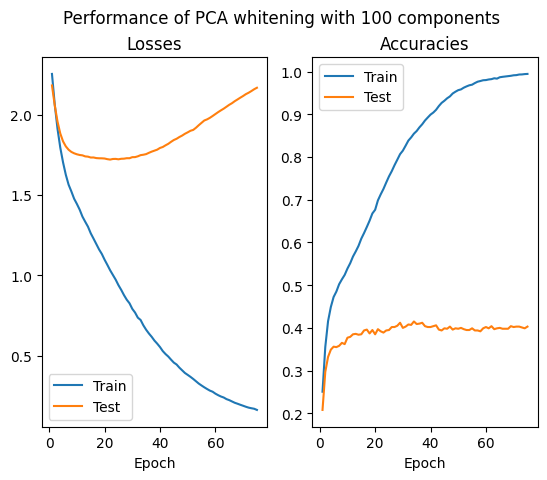

0.16405134883862507 2.1669363006949425 0.9944 0.403


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), pca_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), pca_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), pca_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), pca_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle(f'Performance of PCA whitening with {n_components_root**2} components')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(pca_train_losses[-1], pca_test_losses[-1], pca_train_accuracies[-1], pca_test_accuracies[-1])

## Section 6 - Network width

In [ ]:
widths = [6, 10, 12]
width_train_losses, width_test_losses = [[] for i in range(3)], [[] for i in range(3)]
width_train_accuracies, width_test_accuracies = [[] for i in range(3)], [[] for i in range(3)]
for i in range(len(widths)):
  net = FFNet(hidden_size=(2 ** widths[i]), std=best_hyperparams[0])
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
  width_train_losses[i], width_test_losses[i], width_train_accuracies[i], width_test_accuracies[i] = train(optimizer, criterion, net, num_epoch=num_epoch, history=True)

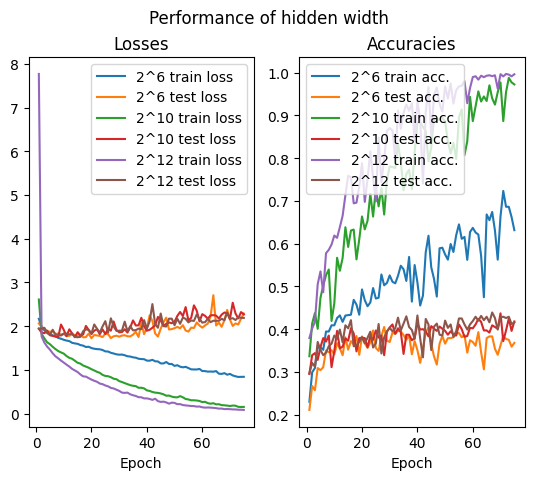

0.8406061794184432 2.288851633667946 0.6316 0.368
0.15233601601440697 2.267904244363308 0.9726 0.418
0.08351297374767593 2.1884525194764137 0.9964 0.416


In [ ]:
plt.subplot(1, 2, 1)
for i in range(len(widths)):
  plt.plot(range(1, num_epoch+1), width_train_losses[i], label = f'2^{widths[i]} train loss')
  plt.plot(range(1, num_epoch+1), width_test_losses[i], label = f'2^{widths[i]} test loss')
  plt.xlabel("Epoch")
  plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(widths)):
  plt.plot(range(1, num_epoch+1), width_train_accuracies[i], label = f'2^{widths[i]} train acc.')
  plt.plot(range(1, num_epoch+1), width_test_accuracies[i], label = f'2^{widths[i]} test acc.')
  plt.xlabel("Epoch")
  plt.legend()
plt.suptitle('Performance of hidden width')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()

for i in range(len(widths)):
  print(width_train_losses[i][-1], width_test_losses[i][-1], width_train_accuracies[i][-1], width_test_accuracies[i][-1])

## Section 7 - Network depth

In [ ]:
depth_train_losses, depth_test_losses = [[] for i in range(3)], [[] for i in range(3)]
depth_train_accuracies, depth_test_accuracies = [[] for i in range(3)], [[] for i in range(3)]
depths = [3, 4, 10]
for i in range(len(depths)):
  net = FFNet(depth=depths[i], std=best_hyperparams[0])
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
  depth_train_losses[i], depth_test_losses[i], depth_train_accuracies[i], depth_test_accuracies[i] = train(optimizer, criterion, net, num_epoch=num_epoch, history=True)

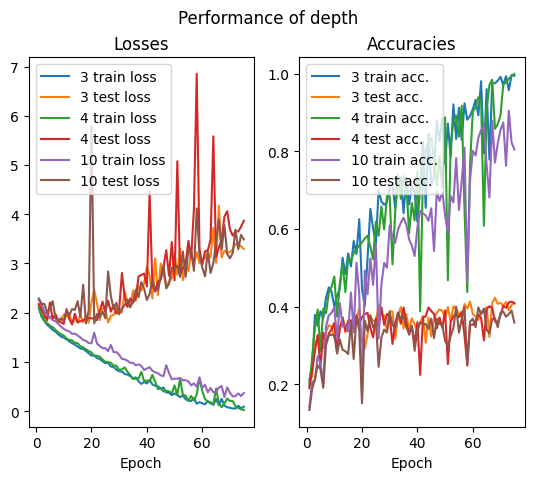

0.0911386411495601 3.2945044934749603 0.9946 0.409
0.025532947811946462 3.867580831050873 0.9994 0.409
0.36968504684635356 3.4885050505399704 0.8046 0.359


In [ ]:
plt.subplot(1, 2, 1)
for i in range(len(depths)):
  plt.plot(range(1, num_epoch+1), depth_train_losses[i], label = f'{depths[i]} train loss')
  plt.plot(range(1, num_epoch+1), depth_test_losses[i], label = f'{depths[i]} test loss')
  plt.xlabel("Epoch")
  plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(widths)):
  plt.plot(range(1, num_epoch+1), depth_train_accuracies[i], label = f'{depths[i]} train acc.')
  plt.plot(range(1, num_epoch+1), depth_test_accuracies[i], label = f'{depths[i]} test acc.')
  plt.xlabel("Epoch")
  plt.legend()
plt.suptitle('Performance of depth')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()

for i in range(len(widths)):
  print(depth_train_losses[i][-1], depth_test_losses[i][-1], depth_train_accuracies[i][-1], depth_test_accuracies[i][-1])

# Part 3 - Convolutional neural net

## Section 1
### General convolutional network setup

In [ ]:
input_size = 32
class ConvNet(nn.Module):
    def __init__(self, input_size=input_size, filter_size_1=64, filter_size_2=16, output_size=10, depth=2, 
                 xavier=False, std=1, dropout=False, p=0.5):
        '''
        Initializes a ConvNet that receives image tensors for which the square matrix in each channel is of size input_size*input_size. 
        Each hidden layer is composed of a convolutional layer, a ReLU layer and a max pooling layer. 
        Odd convolutional layers have filters of size filter_size_1, even convolutional layers have filters of size filter_size_2.
        The last two layers are fully connected linear ones.
        The output layer is of size output_size.
        The net has depth hidden layers.
        xavier is a flag for initializing the net's weights with xavier's initialization.
        std is a parameter used for the normal initialization of the weights.
        dropout is a flag for including a dropout layer after every hidden layer.
        The dropout probability is p.
        '''
        super(ConvNet, self).__init__()
        self.std = std # Standard deviation for normal init.
        self.out_channels = filter_size_2 if depth % 2 == 0 else filter_size_1 # Number of convolutional output channels
        self.transformed_size = input_size // (2**depth) # Number of convolutional output pixels (with zero padding)

        self.conv_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=filter_size_1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=filter_size_1, out_channels=filter_size_2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Base convolutional setup
        if dropout: # Dropout layer
          self.conv_model.append(nn.Dropout(p))
        for l in range(depth-2): # Depth
          if l % 2 == 0:
            self.conv_model.append(nn.Conv2d(in_channels=filter_size_2, out_channels=filter_size_1, kernel_size=3, stride=1, padding=1))
          else:
            self.conv_model.append(nn.Conv2d(in_channels=filter_size_1, out_channels=filter_size_2, kernel_size=3, stride=1, padding=1))
          self.conv_model.append(nn.ReLU())
          self.conv_model.append(nn.MaxPool2d(kernel_size=2, stride=2))
          if dropout: # Dropout layer
            self.conv_model.append(nn.Dropout(p))
        
        self.fc_model = nn.Sequential(
            nn.Linear(self.out_channels * (self.transformed_size ** 2), 784),
            nn.Linear(784, output_size)) # Base fully connected setup
        
        if xavier: # Xavier init.
          self.xavier_init()
        else: # Normal init.
          self.normal_init()

    def xavier_init(self):
      for module in self.conv_model:
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
          torch.nn.init.xavier_uniform_(module.weight)
          torch.nn.init.zeros_(module.bias)
      for module in self.fc_model:
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
          torch.nn.init.xavier_uniform_(module.weight)
          torch.nn.init.zeros_(module.bias)

    def normal_init(self):
      for module in self.conv_model:
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
          torch.nn.init.normal_(module.weight, mean=0, std=self.std)
          torch.nn.init.normal_(module.bias, mean=0, std=self.std)
      for module in self.fc_model:
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
          torch.nn.init.normal_(module.weight, mean=0, std=self.std)
          torch.nn.init.normal_(module.bias, mean=0, std=self.std)
    
    def forward(self, x):
        out = self.conv_model(x)
        out = out.view(-1, self.out_channels * (self.transformed_size**2)) # Flatten convolutional output to fit into fully connected setup
        out = self.fc_model(out)
        return out

### Move data to GPU

In [ ]:
gpu_train_loader = [(inputs.cuda(), labels.cuda()) for inputs, labels in train_loader]
gpu_test_loader = [(inputs.cuda(), labels.cuda()) for inputs, labels in test_loader]

### Hyperparameters grid search

In [ ]:
num_epoch = 25
best_accuracy = 0
best_hyperparams = (0, 0, 0)

for std in [2**i for i in range(-4,0)]:
  for lr in [10**(-i) for i in range(1, 4)]:
    for momentum in [0.95-(i*0.1) for i in range(1, 4)]:
      print(f'std: {std}, lr: {lr}, momentum: {momentum}')
      net = ConvNet(std=std) # Initialize net
      net.cuda() # Use GPU
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum) # Initialize optimizer
      train(optimizer, criterion, net, num_epoch=num_epoch, training=gpu_train_loader, test=gpu_test_loader, history=False, conv=True) # Train model
      curr_accuracy = accuracy(net, train_acc=False, conv=True, training=gpu_train_loader, test=gpu_test_loader) # Compute accuracy
      if (best_accuracy <= curr_accuracy):
        print(curr_accuracy)
        best_accuracy = curr_accuracy
        best_hyperparams = (std, lr, momentum)

std: 0.0625, lr: 0.1, momentum: 0.85
0.1
std: 0.0625, lr: 0.1, momentum: 0.75
0.302
std: 0.0625, lr: 0.1, momentum: 0.6499999999999999
0.386
std: 0.0625, lr: 0.01, momentum: 0.85
0.442
std: 0.0625, lr: 0.01, momentum: 0.75
0.449
std: 0.0625, lr: 0.01, momentum: 0.6499999999999999
0.463
std: 0.0625, lr: 0.001, momentum: 0.85
std: 0.0625, lr: 0.001, momentum: 0.75
std: 0.0625, lr: 0.001, momentum: 0.6499999999999999
std: 0.125, lr: 0.1, momentum: 0.85
std: 0.125, lr: 0.1, momentum: 0.75
std: 0.125, lr: 0.1, momentum: 0.6499999999999999
std: 0.125, lr: 0.01, momentum: 0.85
std: 0.125, lr: 0.01, momentum: 0.75
std: 0.125, lr: 0.01, momentum: 0.6499999999999999
std: 0.125, lr: 0.001, momentum: 0.85
std: 0.125, lr: 0.001, momentum: 0.75
std: 0.125, lr: 0.001, momentum: 0.6499999999999999
std: 0.25, lr: 0.1, momentum: 0.85
std: 0.25, lr: 0.1, momentum: 0.75
std: 0.25, lr: 0.1, momentum: 0.6499999999999999
std: 0.25, lr: 0.01, momentum: 0.85
std: 0.25, lr: 0.01, momentum: 0.75
std: 0.25, lr: 0

### Best configuration evaluation

In [ ]:
num_epoch = 75
net = ConvNet(std=best_hyperparams[0])
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
base_train_losses, base_test_losses, base_train_accuracies, base_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, 
                                                                                         training=gpu_train_loader, test=gpu_test_loader,
                                                                                         history=True, conv=True)

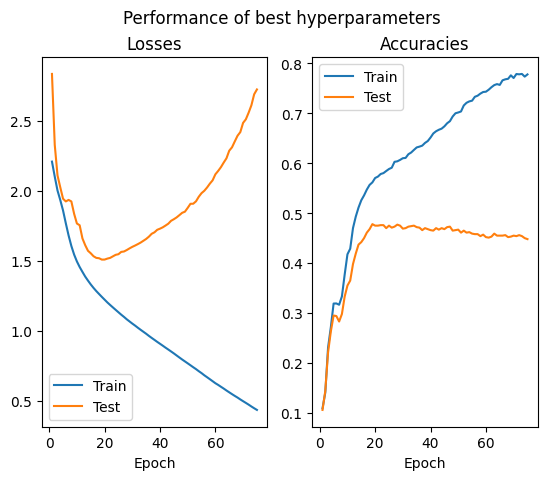

0.4358299034588699 2.7256245464086533 0.7778 0.448


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), base_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), base_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), base_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), base_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle('Performance of best hyperparameters')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(base_train_losses[-1], base_test_losses[-1], base_train_accuracies[-1], base_test_accuracies[-1])

## Section 2 - Adam optimizer

In [ ]:
net = ConvNet(std=best_hyperparams[0])
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=best_hyperparams[1])
adam_train_losses, adam_test_losses, adam_train_accuracies, adam_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, 
                                                                                         training=gpu_train_loader, test=gpu_test_loader,
                                                                                         history=True, conv=True)

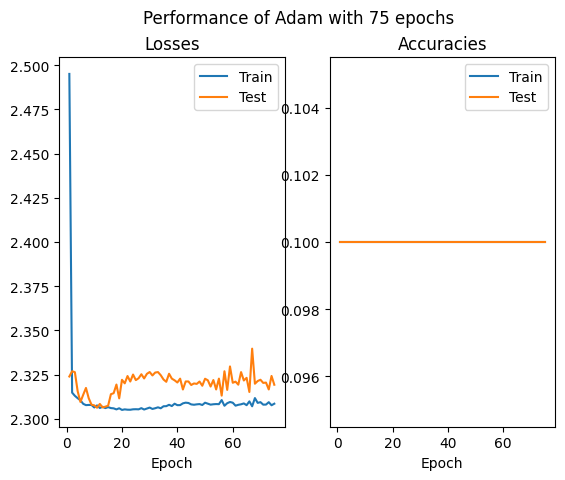

2.3085328778134118 2.3192577809095383 0.1 0.1


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), adam_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), adam_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), adam_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), adam_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle(f'Performance of Adam with {num_epoch} epochs')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(adam_train_losses[-1], adam_test_losses[-1], adam_train_accuracies[-1], adam_test_accuracies[-1])

In [ ]:
net = ConvNet(std=best_hyperparams[0])
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
adam_train_losses, adam_test_losses, adam_train_accuracies, adam_test_accuracies = train(optimizer, criterion, net, num_epoch=100, 
                                                                                         training=gpu_train_loader, test=gpu_test_loader,
                                                                                         history=True, conv=True)

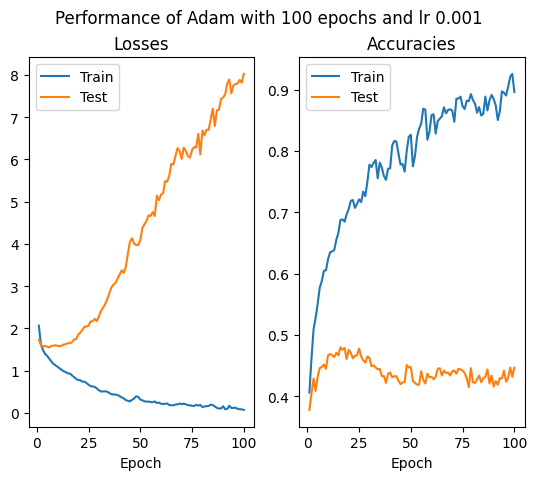

0.07250128071047837 8.025067448616028 0.8958 0.447


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, 100+1), adam_train_losses, label = "Train")
plt.plot(range(1, 100+1), adam_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, 100+1), adam_train_accuracies, label = "Train")
plt.plot(range(1, 100+1), adam_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle(f'Performance of Adam with {100} epochs and lr {0.001}')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(adam_train_losses[-1], adam_test_losses[-1], adam_train_accuracies[-1], adam_test_accuracies[-1])

## Section 3 - Xavier initialization

In [ ]:
net = ConvNet(xavier=True)
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
xav_train_losses, xav_test_losses, xav_train_accuracies, xav_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, 
                                                                                         training=gpu_train_loader, test=gpu_test_loader,
                                                                                         history=True, conv=True)

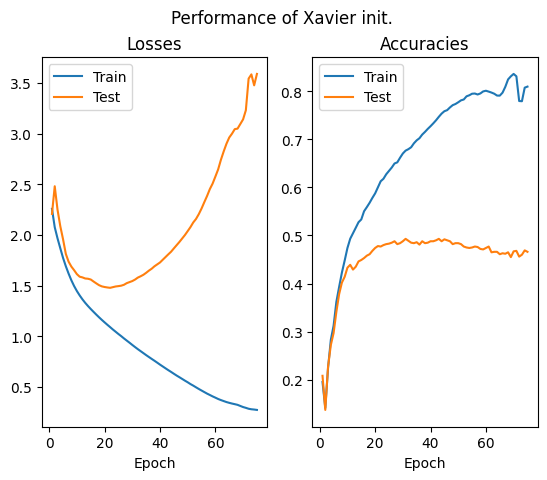

0.2748674511544029 3.5889151245355606 0.8098 0.466


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), xav_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), xav_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), xav_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), xav_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle('Performance of Xavier init.')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(xav_train_losses[-1], xav_test_losses[-1], xav_train_accuracies[-1], xav_test_accuracies[-1])

## Section 4 - Regularization
### Weight decay

In [ ]:
net = ConvNet(std=best_hyperparams[0])
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2], weight_decay=0.2)
wd_train_losses, wd_test_losses, wd_train_accuracies, wd_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, 
                                                                                         training=gpu_train_loader, test=gpu_test_loader,
                                                                                         history=True, conv=True)

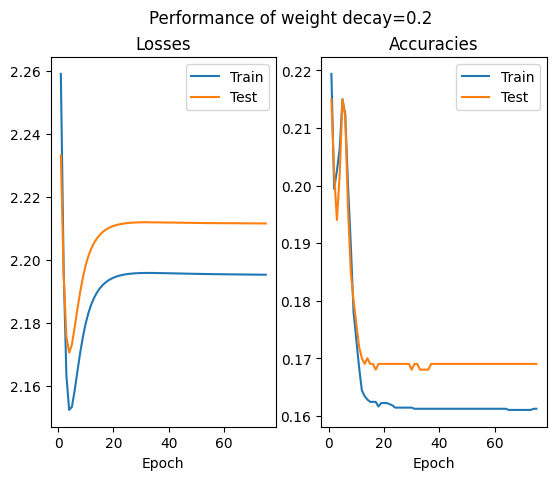

2.195284933983525 2.2115405052900314 0.1612 0.169


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), wd_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), wd_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), wd_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), wd_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle('Performance of weight decay=0.2')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(wd_train_losses[-1], wd_test_losses[-1], wd_train_accuracies[-1], wd_test_accuracies[-1])

### Dropout

In [ ]:
net = ConvNet(std=best_hyperparams[0], dropout=True)
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
drop_train_losses, drop_test_losses, drop_train_accuracies, drop_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch, 
                                                                                         training=gpu_train_loader, test=gpu_test_loader,
                                                                                         history=True, conv=True)

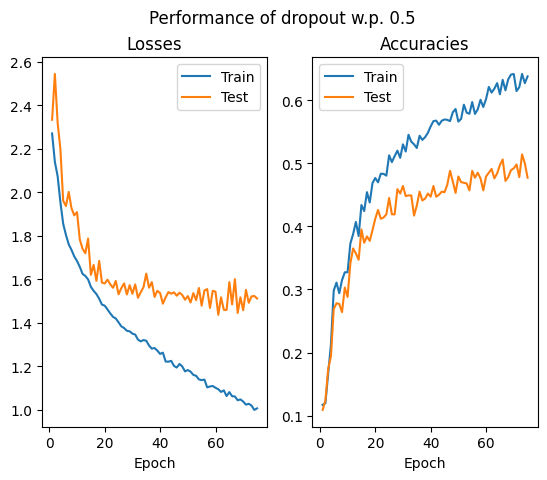

1.0056724644537214 1.5111828818917274 0.6378 0.477


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), drop_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), drop_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), drop_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), drop_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle('Performance of dropout w.p. 0.5')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(drop_train_losses[-1], drop_test_losses[-1], drop_train_accuracies[-1], drop_test_accuracies[-1])

## Section 5 - PCA whitening

In [ ]:
n_components_sq = 10
pca = PCA(3*n_components_sq ** 2, whiten=True)
pca.fit(np.concatenate((X_train, X_test), axis=0))

PCA(n_components=300, whiten=True)

In [ ]:
def PCA_transform(image, model=pca, n_components_sq=n_components_sq):
  X = transforms.functional.to_tensor(image)
  X = np.array(X).flatten()
  X = model.transform(X.reshape(1, -1))
  return torch.Tensor(X.reshape((3, n_components_sq, n_components_sq)))

In [ ]:
train_dataset_pca = dsets.CIFAR10(root='./data', train=True, # Read training set
                              download=True, transform=PCA_transform)
test_dataset_pca = dsets.CIFAR10(root='./data', train=False, # Read test set
                        download=True, transform=PCA_transform)
train_dataset_pca, _ = train_test_split(train_dataset_pca, train_size=0.1, stratify=train_dataset_pca.targets, random_state=1) # Extract 10% of the data
_, test_dataset_pca = train_test_split(test_dataset_pca, test_size=0.1, stratify=test_dataset_pca.targets, random_state=1) # Extract 10% of the data

train_loader_pca = torch.utils.data.DataLoader(train_dataset_pca, batch_size=batch_size, # Partition to batches
                                          shuffle=True)
train_loader_pca = [(inputs.cuda(), labels.cuda()) for inputs, labels in train_loader_pca]
test_loader_pca = torch.utils.data.DataLoader(test_dataset_pca, batch_size=batch_size, # Partition to batches
                                         shuffle=False)
test_loader_pca = [(inputs.cuda(), labels.cuda()) for inputs, labels in test_loader_pca]

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
net = ConvNet(input_size=n_components_sq, std=best_hyperparams[0])
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
pca_train_losses, pca_test_losses, pca_train_accuracies, pca_test_accuracies = train(optimizer, criterion, net, num_epoch=num_epoch,
                                                                                    history=True, conv=True,
                                                                                    training=train_loader_pca, test=test_loader_pca)

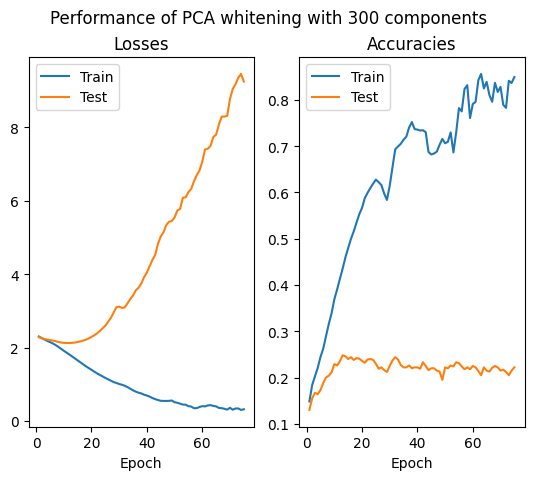

0.31696567326029645 9.251988768577576 0.8494 0.222


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epoch+1), pca_train_losses, label = "Train")
plt.plot(range(1, num_epoch+1), pca_test_losses, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epoch+1), pca_train_accuracies, label = "Train")
plt.plot(range(1, num_epoch+1), pca_test_accuracies, label = "Test")
plt.xlabel("Epoch")
plt.legend()
plt.suptitle(f'Performance of PCA whitening with {3*n_components_sq**2} components')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()
print(pca_train_losses[-1], pca_test_losses[-1], pca_train_accuracies[-1], pca_test_accuracies[-1])

## Section 6 - Filter size

In [ ]:
filters = [(256, 64), (512, 256)]
filter_train_losses, filter_test_losses = [[] for i in range(2)], [[] for i in range(2)]
filter_train_accuracies, filter_test_accuracies = [[] for i in range(2)], [[] for i in range(2)]
for i in range(len(filters)):
  net = ConvNet(filter_size_1=filters[i][0], filter_size_2=filters[i][1], std=best_hyperparams[0])
  net.cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
  filter_train_losses[i], filter_test_losses[i], filter_train_accuracies[i], filter_test_accuracies[i] = train(optimizer, criterion, net, num_epoch=num_epoch, 
                                                                                                          training=gpu_train_loader, test=gpu_test_loader,
                                                                                                          history=True, conv=True)

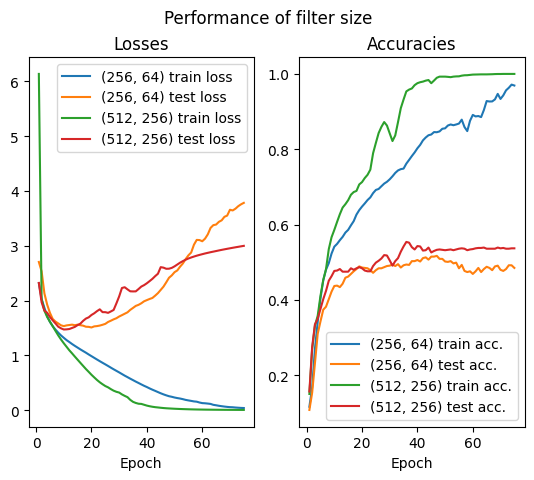

0.04075663736756137 3.7832575887441635 0.9692 0.485
0.006184226770655405 2.998950555920601 1.0 0.537


In [ ]:
plt.subplot(1, 2, 1)
for i in range(len(filters)):
  plt.plot(range(1, num_epoch+1), filter_train_losses[i], label = f'{filters[i]} train loss')
  plt.plot(range(1, num_epoch+1), filter_test_losses[i], label = f'{filters[i]} test loss')
  plt.xlabel("Epoch")
  plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(filters)):
  plt.plot(range(1, num_epoch+1), filter_train_accuracies[i], label = f'{filters[i]} train acc.')
  plt.plot(range(1, num_epoch+1), filter_test_accuracies[i], label = f'{filters[i]} test acc.')
  plt.xlabel("Epoch")
  plt.legend()
plt.suptitle('Performance of filter size')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()

for i in range(len(filters)):
  print(filter_train_losses[i][-1], filter_test_losses[i][-1], filter_train_accuracies[i][-1], filter_test_accuracies[i][-1])

## Section 7 - Network depth

In [ ]:
depth_train_losses, depth_test_losses = [[] for i in range(3)], [[] for i in range(3)]
depth_train_accuracies, depth_test_accuracies = [[] for i in range(3)], [[] for i in range(3)]
depths = [3, 4, 5]
for i in range(len(depths)):
  net = ConvNet(depth=depths[i], std=best_hyperparams[0])
  net.cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=best_hyperparams[1], momentum=best_hyperparams[2])
  depth_train_losses[i], depth_test_losses[i], depth_train_accuracies[i], depth_test_accuracies[i] = train(optimizer, criterion, net, num_epoch=num_epoch, 
                                                                                                          training=gpu_train_loader, test=gpu_test_loader,
                                                                                                          history=True, conv=True)

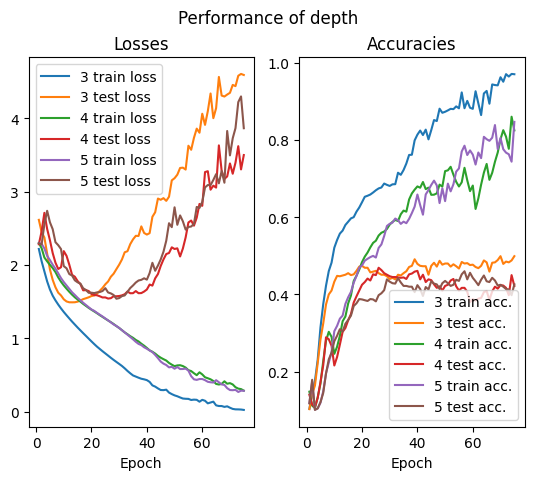

0.026688252151111154 4.589587137103081 0.97 0.499
0.28950881366205367 3.498747408390045 0.8246 0.422
0.2869168783927077 3.864181265234947 0.8466 0.426


In [ ]:
plt.subplot(1, 2, 1)
for i in range(len(depths)):
  plt.plot(range(1, num_epoch+1), depth_train_losses[i], label = f'{depths[i]} train loss')
  plt.plot(range(1, num_epoch+1), depth_test_losses[i], label = f'{depths[i]} test loss')
  plt.xlabel("Epoch")
  plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(depths)):
  plt.plot(range(1, num_epoch+1), depth_train_accuracies[i], label = f'{depths[i]} train acc.')
  plt.plot(range(1, num_epoch+1), depth_test_accuracies[i], label = f'{depths[i]} test acc.')
  plt.xlabel("Epoch")
  plt.legend()
plt.suptitle('Performance of depth')
plt.subplot(1, 2, 1).set_title('Losses')
plt.subplot(1, 2, 2).set_title('Accuracies')
plt.show()

for i in range(len(depths)):
  print(depth_train_losses[i][-1], depth_test_losses[i][-1], depth_train_accuracies[i][-1], depth_test_accuracies[i][-1])